In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from sklearn.metrics import confusion_matrix
import pandas as pd
from tensorflow.keras import optimizers
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras import regularizers
import os

In [2]:
import os
import pandas as pd
import librosa
import glob 
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
import json

In [3]:
mylist= os.listdir('Audio/')

In [4]:
type(mylist)

list

In [5]:
print(mylist[28])

h8.wav


In [6]:
print(mylist[28][:-2])

h8.w


In [7]:
data, sampling_rate = librosa.load('Audio/h1.wav')

In [8]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


In [9]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('Audio/h1.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

<ipython-input-9-08d00b823f38>:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('Audio/h1.wav')


ValueError: operands could not be broadcast together with shapes (1323,) (1323,2) 

In [10]:
feeling_list=[]
for item in mylist:
    if item[:1]=='c':
        feeling_list.append('confident')
    elif item[:1]=='h':
        feeling_list.append('hesitation')

In [11]:
labels = pd.DataFrame(feeling_list)

In [12]:
labels[:29]

,0
0,confident
1,confident
2,confident
3,confident
4,confident
5,confident
6,confident
7,confident
8,confident
9,confident


In [13]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('Audio/'+y, res_type='kaiser_fast',duration=20,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [14]:
df[:5]

,feature
0,"[-16.820232, -18.45706, -21.608778, -24.4149, ..."
1,"[-7.7447147, -11.703676, -25.931456, -32.00933..."
2,"[-15.132053, -14.90013, -15.525883, -16.528883..."
3,"[-22.422218, -22.121727, -24.5001, -24.51517, ..."
4,"[-40.872288, -36.827137, -22.110006, -14.89120..."


In [15]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [16]:
newdf = pd.concat([df3,labels], axis=1)

In [17]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [18]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,1714,1715,1716,1717,1718,1719,1720,1721,1722,0
9,-20.862511,-23.782749,-33.094265,-29.330128,-24.750637,-22.603283,-22.804173,-24.328539,-24.037811,-26.052145,...,-26.463505,-23.513306,-20.826134,-20.431253,-22.671467,-26.872383,-30.174095,-32.468025,-32.448109,confident
26,-12.421477,-11.878429,-15.390087,-18.352375,-19.291243,-19.885530,-21.758602,-18.974213,-18.627052,-14.877284,...,-16.545683,-18.817238,-19.805641,-18.066189,-14.834322,-12.629364,-10.615644,-9.456968,-5.735039,hesitation
10,-12.969912,-16.658316,-21.682793,-23.392418,-22.954863,-21.531223,-22.601919,-23.863634,-23.803366,-24.303518,...,-36.419827,-37.527794,-37.659836,-38.536125,-39.995888,-39.911636,-40.431942,-42.029800,-37.957878,confident
11,-27.280033,-28.252821,-30.654747,-33.772007,-34.914913,-34.893604,-33.988998,-33.821499,-34.628098,-34.661682,...,-38.697586,-39.823551,-40.575462,-40.159199,-41.102425,-43.910488,-45.139835,-46.125908,-44.824833,confident
14,-18.684284,-19.019203,-15.777334,-10.948073,-9.409962,-9.899128,-9.742911,-10.744406,-9.490953,-9.466778,...,-9.646505,-9.635230,-8.223202,-8.410442,-8.006181,-7.947282,-8.111093,-7.372236,-3.601696,confident
6,-6.965083,-8.847045,-11.462982,-11.868047,-14.538705,-15.529673,-18.192617,-22.544231,-30.824547,-37.538654,...,-14.687154,-15.199187,-15.595686,-15.853916,-15.426380,-16.068384,-16.063745,-16.401760,-12.975442,confident
15,-23.653240,-20.888134,-19.926291,-21.406862,-21.510973,-20.272482,-22.073172,-24.402040,-22.392355,-21.795790,...,-17.884800,-17.593418,-18.117947,-17.495913,-14.607748,-11.323586,-8.971310,-8.688193,-7.374305,hesitation
3,-22.422218,-22.121727,-24.500099,-24.515169,-23.574032,-23.576170,-22.550503,-23.184666,-23.652056,-23.392073,...,-19.434605,-19.059776,-19.933725,-19.788212,-17.884499,-16.150057,-17.644228,-18.854759,-19.167398,confident
18,-22.412476,-24.950457,-27.874882,-26.596357,-27.720091,-30.718985,-31.043692,-32.409927,-33.147598,-33.185978,...,-20.028141,-19.791456,-17.204723,-15.055952,-13.833340,-14.519822,-14.539122,-14.703632,-8.812489,hesitation
23,-21.292349,-21.402475,-26.012331,-24.184505,-22.846863,-24.014097,-23.412519,-23.690763,-16.814714,-11.960642,...,-20.591484,-21.839174,-24.050905,-21.671749,-23.482807,-22.423998,-22.279551,-22.799419,-24.235359,hesitation


In [19]:
rnewdf=rnewdf.fillna(0)

In [20]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [21]:
trainfeatures = train.iloc[:, :-1]

In [22]:
trainlabel = train.iloc[:, -1:]

In [23]:
testfeatures = test.iloc[:, :-1]

In [24]:
testlabel = test.iloc[:, -1:]

In [25]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [26]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [27]:
X_train.shape

(26, 1723)

In [28]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [29]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)


In [30]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [31]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=1, epochs=20, validation_data=(x_testcnn, y_test))

Epoch 1/20
26/26 [==============================] - 5s 123ms/step - loss: 0.7222 - accuracy: 0.4647 - val_loss: 0.7090 - val_accuracy: 0.5000
Epoch 2/20
26/26 [==============================] - 2s 96ms/step - loss: 0.4532 - accuracy: 0.8274 - val_loss: 0.7130 - val_accuracy: 0.2500
Epoch 3/20
26/26 [==============================] - 2s 96ms/step - loss: 0.3972 - accuracy: 1.0000 - val_loss: 0.7295 - val_accuracy: 0.2500
Epoch 4/20
26/26 [==============================] - 3s 98ms/step - loss: 0.3538 - accuracy: 0.8802 - val_loss: 0.7408 - val_accuracy: 0.2500
Epoch 5/20
26/26 [==============================] - 2s 95ms/step - loss: 0.3332 - accuracy: 0.9220 - val_loss: 0.7590 - val_accuracy: 0.2500
Epoch 6/20
26/26 [==============================] - 2s 96ms/step - loss: 0.2224 - accuracy: 1.0000 - val_loss: 0.8052 - val_accuracy: 0.2500
Epoch 7/20
26/26 [==============================] - 3s 99ms/step - loss: 0.2130 - accuracy: 1.0000 - val_loss: 0.8399 - val_accuracy: 0.0000e+00
Epoch 8/

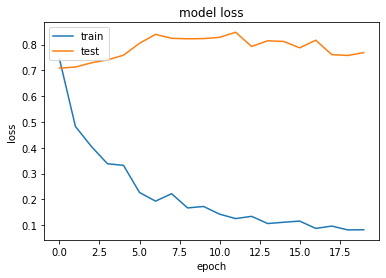

In [32]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models1')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\paperspace\Documents\speech-emotion-detection-master\saved_models1\Emotion_Voice_Detection_Model.h5 


In [62]:
import json
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

In [33]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models1/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 75.00%


In [34]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 428ms/step


In [35]:
preds

array([[0.30025756, 0.6997425 ],
       [0.8864884 , 0.1135116 ],
       [0.54969543, 0.45030463],
       [0.8962797 , 0.10372034]], dtype=float32)

In [36]:
preds1=preds.argmax(axis=1)

In [37]:
preds1

array([1, 0, 0, 0], dtype=int64)

In [38]:
abc = preds1.astype(int).flatten()

In [39]:
predictions = (lb.inverse_transform((abc)))

In [40]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,hesitation
1,confident
2,confident
3,confident


In [41]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [42]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,hesitation
1,confident
2,hesitation
3,confident


In [43]:
finaldf = actualdf.join(preddf)

In [44]:
finaldf[:5]

,actualvalues,predictedvalues
0,hesitation,hesitation
1,confident,confident
2,hesitation,confident
3,confident,confident


In [45]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
confident,2
hesitation,2


In [46]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
confident,3
hesitation,1


In [47]:
data, sampling_rate = librosa.load('Test/Dhruva 4.wav')

In [48]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

UsageError: Line magic function `%` not found.


In [139]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('Test/Feroz 1.wav', res_type='kaiser_fast',duration=20,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [140]:
livedf2= pd.DataFrame(data=livedf2)

In [141]:
livedf2 = livedf2.stack().to_frame().T

In [142]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-6.737062,-8.566372,-12.704545,-12.363185,-9.612091,-7.091426,-7.824143,-8.815116,-6.671105,-7.802322,...,-32.06916,-32.170589,-29.931431,-19.083368,-14.927387,-13.61432,-12.996624,-14.171197,-12.161076,-4.420917


In [143]:
twodim= np.expand_dims(livedf2, axis=2)

In [144]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 45ms/step


In [145]:
livepreds

array([[0.65749586, 0.34250414]], dtype=float32)

In [146]:
livepreds1=livepreds.argmax(axis=1)

In [147]:
liveabc = livepreds1.astype(int).flatten()

In [148]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['confident'], dtype=object)